In [1]:
# Load the important files
from prepare_data import *
from data import *

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

In [3]:
import math
import matplotlib.pyplot as plt

In [4]:
training_address="food-101/train.csv"
test_address="food-101/test.csv"

In [5]:
train,val,test=get_dataloaders(training_address, test_address, args=None)

# Custom Model

In [6]:
import torch.optim as optim
import torch.nn.functional as F
def prepare_model(device, model):
    # load model, criterion, optimizer, and learning rate scheduler
    
    # Create an empty model and move it to the designated computing device
    model=model.to(device)


    return model

def train_single_model(model, criterion, optimizer, scheduler, device, dataloaders,epoch):
    
    # prepare the model
    model=prepare_model(device,model)
    
    # store the results of our training
    training_losses=[]
    training_accs=[]
    val_losses=[]
    val_accs=[]

    for i in range(epoch):
        # train the model in each epoch
        model.train()
        for batch_idx, (data, target) in enumerate(dataloaders[0]):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad() # clear the old gradients 
            output = model(data) # compute outputs of the fc layer 
            loss = criterion(output, target) 
            loss.backward() # compute gradient for every variables with requires_grad=True
            optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        print("finish a epoch of training")
            
        # test the model with the training data:
        model.eval() # sets model in evaluation (inference) mode. Q3. Why? 
        training_loss = 0 
        correct = 0
        with torch.no_grad(): # stop storing gradients for the variables
            for data, target in dataloaders[0]:
                data, target = data.to(device), target.to(device)
                output = model(data)
                training_loss+=criterion(output, target)
                pred = output.argmax(dim=1, keepdim=True) # get the index of maximum fc output. Q4. Why?
                correct += pred.eq(target.view_as(pred)).sum().item()
        training_loss /= len(dataloaders[0].dataset)
        training_losses.append(training_loss)
        training_acc=correct / len(dataloaders[0].dataset)
        training_accs.append(training_acc)
        
        
        # test the model with validation data in each epoch
        model.eval() # sets model in evaluation (inference) mode. Q3. Why? 
        val_loss = 0 
        correct = 0
        with torch.no_grad(): # stop storing gradients for the variables
            for data, target in dataloaders[1]:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss+=criterion(output, target)
                pred = output.argmax(dim=1, keepdim=True) # get the index of maximum fc output. Q4. Why?
                correct += pred.eq(target.view_as(pred)).sum().item()
        val_loss /= len(dataloaders[1].dataset)
        val_losses.append(val_loss)
        val_acc=correct / len(dataloaders[1].dataset)
        val_accs.append(val_acc)
        print("epoch_num: "+str(i))
        print("train accu: ",training_acc)
        print("train_loss: "+str(training_loss))
        print("val_loss: "+str(val_loss))

    torch.save(model.state_dict(), "food-101/state_dict_model.pt")
    return model,training_losses,training_accs,val_losses,val_accs

In [7]:
a=[train,val,test]

In [8]:
class custom(nn.Module):
    def __init__(self):
        super(custom, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
        self.BN1=nn.BatchNorm2d(64)
        self.drop_out3=nn.Dropout(p=0.2)
        
        self.conv2= nn.Conv2d(64, 128, kernel_size=3)
        self.BN2=nn.BatchNorm2d(128)
        
        
        self.conv3= nn.Conv2d(128, 256, kernel_size=3)
        self.BN3=nn.BatchNorm2d(256)
        
        self.avg_pool1 = nn.AdaptiveAvgPool2d((107, 107))
        
        self.conv4= nn.Conv2d(256, 256, kernel_size=3)
        self.BN4=nn.BatchNorm2d(256)
        
        
        self.conv5= nn.Conv2d(256, 512, kernel_size=3)
        self.BN5=nn.BatchNorm2d(512)
        self.max3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.conv6= nn.Conv2d(512, 128, kernel_size=3,stride=2)
        self.BN6=nn.BatchNorm2d(128)
        self.max4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.avg_pool=nn.AdaptiveAvgPool2d(1)
        
        # Compute the input units using the formula given in discussion session 128*63*63
        self.fc1=nn.Linear(128, 128)
        self.drop_out=nn.Dropout()
        self.fc2=nn.Linear(128,20)
        
    def forward(self, x):
        # layer1
        x=self.conv1(x)
        x=self.BN1(x)
        x=F.relu(self.drop_out3(x))
        
        # Layer2
        x=self.conv2(x)
        x=self.BN2(x)
        x=F.relu(x)
        
        # Layer3
        x=self.conv3(x)
        x=self.BN3(x)
        x=F.relu(x)
        
        x = self.avg_pool1(x)
        
        # Layer4
        x=self.conv4(x)
        x=self.BN4(x)
        x=F.relu(x)
        x=F.max_pool2d(x,3)
        
        # Layer5
        x=self.conv5(x)
        x=self.BN5(x)
        x=F.relu(x)
        x=self.max3(x)
        
        # Layer6
        x=self.conv6(x)
        x=self.BN6(x)
        x=F.relu(x)
        x=self.max4(x)
        
        x=self.avg_pool(x)
        # fully connected layer 1
        x=x.view(-1,128) # faltten the input
        x=self.fc1(x)
        x=F.relu(self.drop_out(x))
        # fully connected layer 2
        x=self.fc2(x)
        return x

In [9]:
model=custom()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)
def Xavier_Initialization(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.normal_(m.bias.data, mean=0.0, std=1.0)
model.apply(Xavier_Initialization)

custom(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_out3): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (BN2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (BN3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool1): AdaptiveAvgPool2d(output_size=(107, 107))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (BN4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (BN5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv6): Conv2d(512, 128, kernel_size=(3, 3

In [10]:
aa,bb,cc,dd,ee = train_single_model(model, criterion, optimizer, scheduler=None, device="cuda:0", dataloaders=a,epoch=30)

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


finish a epoch of training
epoch_num: 0
train accu:  0.22008333333333333
train_loss: tensor(0.1589, device='cuda:0')
val_loss: tensor(0.1590, device='cuda:0')
finish a epoch of training
epoch_num: 1
train accu:  0.23208333333333334
train_loss: tensor(0.1542, device='cuda:0')
val_loss: tensor(0.1549, device='cuda:0')
finish a epoch of training
epoch_num: 2
train accu:  0.2655
train_loss: tensor(0.1502, device='cuda:0')
val_loss: tensor(0.1508, device='cuda:0')
finish a epoch of training
epoch_num: 3
train accu:  0.28833333333333333
train_loss: tensor(0.1456, device='cuda:0')
val_loss: tensor(0.1467, device='cuda:0')
finish a epoch of training
epoch_num: 4
train accu:  0.29633333333333334
train_loss: tensor(0.1430, device='cuda:0')
val_loss: tensor(0.1436, device='cuda:0')
finish a epoch of training
epoch_num: 5
train accu:  0.31516666666666665
train_loss: tensor(0.1407, device='cuda:0')
val_loss: tensor(0.1410, device='cuda:0')
finish a epoch of training
epoch_num: 6
train accu:  0.3149

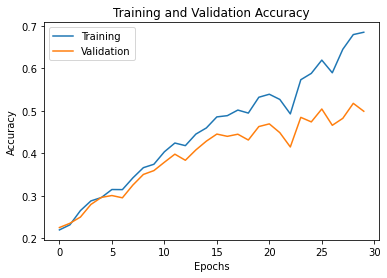

In [11]:
plt.plot(cc, label='Training')
plt.plot(ee, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

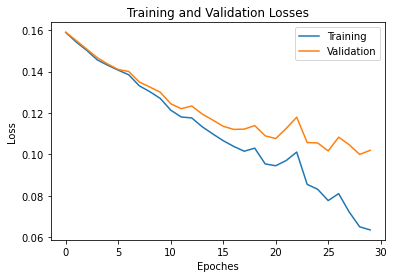

In [12]:
plt.plot(bb, label='Training')
plt.plot(dd, label='Validation')
plt.title('Training and Validation Losses')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
aa

custom(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_out3): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (BN2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (BN3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool1): AdaptiveAvgPool2d(output_size=(107, 107))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (BN4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (BN5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv6): Conv2d(512, 128, kernel_size=(3, 3

# Test Accuracy

In [14]:
aa.eval() # sets model in evaluation (inference) mode.
correct = 0
with torch.no_grad(): # stop storing gradients for the variables
    for data, target in a[2]:
            data, target = data.to("cuda:0"), target.to("cuda:0")
            output = aa(data)
            pred = output.argmax(dim=1, keepdim=True) # get the index of maximum fc output. 
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_acc=correct / len(a[2].dataset)
print("test accu: ",test_acc)

test accu:  0.4748


conv1(out_channels=64, kernel_size=3)+BN+ReLU

                 -> conv2(out_channels=64, kernel_size=3)+BN+ReLU
                 -> conv3(out_channels=64, kernel_size=3)+BN+ReLU -> maxpool1(kernel_size=3)
                 -> conv4(out_channels=128, kernel_size=3, stride=2)+BN+ReLU
                 
                 -> conv5(out_channels=128, kernel_size=3, stride=2)+BN+ReLU
                 -> conv6(out_channels=128, kernel_size=3, stride=2)+BN+ReLU
                 
                 -> adaptiveavgpool(output_size=1x1)
                 -> fc1(out_features=128)+dropout+ReLU -> fc2(out_features=num_classes)
                 

In [15]:
#save weights
torch.save(aa.state_dict(),"food-101/state_dict_model1.pt")

In [16]:
#load model
model = models.custom() # we do not specify pretrained=True, i.e. do not load default weights
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

AttributeError: module 'torchvision.models' has no attribute 'custom'

# weight

In [ ]:
w = aa.conv1.weight.data.cpu()
plt.figure(figsize=(4, 4))
for i, filter in enumerate(w):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach())
    plt.axis('off')
plt.show()
plt.clf()

In [ ]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


# Feature

In [ ]:
test0= None
for i in a[2]:
    test0=i
    break
test0[0].shape

In [ ]:
test0[0].unsqueeze_(0).shape

In [ ]:
model = aa
# custom model: initial layer
model.conv1.register_forward_hook(get_activation('Conv2d'))
data, _ = test0[0]
data.unsqueeze_(0)
output = model(data.cuda())
act = activation['Conv2d'].squeeze()
plt.figure(figsize=(20, 17))
for i, feature in enumerate(act):
    plt.subplot(8, 8, i + 1)
    plt.imshow(feature.cpu())
    plt.axis("off")
plt.show()
plt.clf


# # custom model: middle layer
# model.b6.register_forward_hook(get_activation('Conv2d'))
# data, _ = trainer.test_dataset[0]
# data.unsqueeze_(0)
# output = model(data.cuda())
# act = activation['Conv2d'].squeeze()
# plt.figure(figsize=(20, 17))
# for i, feature in enumerate(act):
#     plt.subplot(16, 16, i + 1)
#     plt.imshow(feature.cpu())
#     plt.axis("off")
#     plt.savefig('images/custom_middle.png')
# plt.show()
# plt.clf


# custom model: final layer
# model.b6.register_forward_hook(get_activation('conv2d'))
# data, _ = trainer.test_dataset[0]
# data.unsqueeze_(0)
# output = model(data.cuda())
# act = activation['conv2d'].squeeze()
# plt.figure(figsize=(20, 17))
# for i, feature in enumerate(act):
#     plt.subplot(16, 16, i + 1)
#     plt.imshow(feature.cpu())
#     plt.axis("off")
#     plt.savefig('images/custom_end.png')
# plt.show()
# plt.clf
